### Project outline: 

- Read data into Jupyter notebook, use pandas to import data into a data frame
- Preprocess data: Explore data, check for missing data and apply data scaling. Justify the type of scaling used.
- Goal is to predict the **total transaction revenue**. 
- Decide aboute a good evaluation strategy and justify your choice.
- Split dataset into train and test dataset. 
- Choose two supervised learning model of your choice to train on train set. Use proper methods to find the best parameters. Evaluate your method on test data according to evaluation strategy. 
- Choose two unsupervised learning models, clustering, to train on your dataset. Discuss results. 
- Choose two unsupervised learning models, dimentionally reduction, and train it your dataset. Now use the same supervised learning models above on reduced dataset. Can you see any differences? Discuss the result. 
- Use a neural network model on your dataset. Compare the result with other two supervised learning models. Which model performs better? 

### Deliverables:
- Submit IPython notebook. Use markdown to provide an inline comments for this project.
- Submit only one notebook. Before submitting, make sure everything runs as expected. To check that, restart the kernel (in the menubar, select Kernel > Restart) and then run all cells (in the menubar, select Cell > Run All).
- Visualization expected. 

### Dataset Description
This is an online Merchandise Store customer dataset. Goal is to predict the total transaction revenue. 
Each row in the dataset is one visit to the store. 

Data Fields
- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- sessionId - A unique identifier for this visit to the store.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp (expressed as POSIX time).
- hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.

In [1]:
#Importing libraries
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas.io.json as pdjson
import seaborn as sns
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Parsing the data - since we have JSON columns but with single quotes 
#I have used ast library to fetch the data in these columng
def data_fetch(csv_path, nrows=None):

    JSON_COLUMNS = ['device', 'geoNetwork', 'trafficSource']

    df = pd.read_csv(csv_path, 
                     converters={column: ast.literal_eval for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    device_list=df['device'].tolist()
    
    #deleting unwanted columns before normalizing
    for device in device_list:
        del device['browserVersion'],device['browserSize'],device['flashVersion'],device['mobileInputSelector'],device['operatingSystemVersion'],device['screenResolution'],device['screenColors']
    df['device']=pd.Series(device_list)
    geoNetwork_list=df['geoNetwork'].tolist()
    for network in geoNetwork_list:
        del network['latitude'],network['longitude'],network['networkLocation'],network['cityId']
    df['geoNetwork']=pd.Series(geoNetwork_list)
    
    df['hits']=df['hits'].apply(ast.literal_eval)
    df['hits']=df['hits'].str[0]
    df['hits']=df['hits'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)
    
    df['customDimensions']=df['customDimensions'].apply(ast.literal_eval)
    df['customDimensions']=df['customDimensions'].str[0]
    df['customDimensions']=df['customDimensions'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)
    
    JSON_COLUMNS = ['device', 'geoNetwork', 'trafficSource','hits','customDimensions']
    for column in JSON_COLUMNS:
        column_as_df = pdjson.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    
    return df

In [3]:
#Calling function to parse the data
df = data_fetch("data.csv")
df2 = df
data = df

#### EDA

In [4]:
df.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,...,hits_referer,hits_social.hasSocialSourceReferral,hits_social.socialInteractionNetworkAction,hits_social.socialNetwork,hits_time,hits_transaction.currencyCode,hits_type,hits_value,customDimensions_index,customDimensions_value
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,1.0,1,1.0,...,https://www.google.co.uk/search?q=water+bottle...,No,:,(not set),0,USD,PAGE,NaN,4,EMEA
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,NaN,2,NaN,...,https://sites.google.com/a/google.com/transpor...,No,:,(not set),0,NaN,PAGE,NaN,4,North America
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,NaN,2,1.0,...,https://www.googlemerchandisestore.com/,No,:,(not set),0,NaN,PAGE,NaN,4,North America
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,NaN,2,1.0,...,https://www.google.com.tr/,No,:,(not set),0,NaN,PAGE,NaN,4,EMEA
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,NaN,2,1.0,...,https://www.google.com.mx/,No,:,(not set),0,NaN,PAGE,NaN,4,Central America


In [5]:
df.shape

(20000, 106)

In [6]:
#Deleting columns that have constant values
#First identifying these columns and then deleting them
for col in df.columns:
    try:
        if (df[col].nunique(dropna=False) == 1):
            del(df[col])
            print(col)
    except TypeError:
        a=df[col].astype('str')
        if (a.nunique(dropna=False) == 1):
            del(df[col])
            print(col)
del(col)


socialEngagementType
totals_visits
device_language
device_mobileDeviceBranding
device_mobileDeviceInfo
device_mobileDeviceMarketingName
device_mobileDeviceModel
trafficSource_adwordsClickInfo.criteriaParameters
hits_index
hits_value


In [7]:
df.shape

(20000, 96)

In [8]:
df.info

<bound method DataFrame.info of       channelGrouping      date        fullVisitorId     visitId  visitNumber  \
0      Organic Search  20171016  3162355547410993243  1508198450            1   
1            Referral  20171016  8934116514970143966  1508176307            6   
2              Direct  20171016  7992466427990357681  1508201613            1   
3      Organic Search  20171016  9075655783635761930  1508169851            1   
4      Organic Search  20171016  6960673291025684308  1508190552            1   
5            Referral  20171016  0166277907528479249  1508196701            1   
6            Referral  20171016  8349655975937271469  1508152478            1   
7      Organic Search  20171016  1332629902468998662  1508206208            1   
8      Organic Search  20171016   632878546807742341  1508207516            1   
9      Organic Search  20171016  1259490915281096752  1508165159            2   
10     Organic Search  20171016  7390444353235629134  1508157285            1

In [9]:
#Removing some json columns with less relevance
df = df.drop(labels=['hits_product'], axis=1)
df = df.drop(labels=['hits_promotion'], axis=1)

In [10]:
#Checking for na
df.isna().any()

channelGrouping                                 False
date                                            False
fullVisitorId                                   False
visitId                                         False
visitNumber                                     False
visitStartTime                                  False
totals_bounces                                   True
totals_hits                                     False
totals_newVisits                                 True
totals_pageviews                                 True
totals_sessionQualityDim                         True
totals_timeOnSite                                True
totals_totalTransactionRevenue                   True
totals_transactionRevenue                        True
totals_transactions                              True
device_browser                                  False
device_deviceCategory                           False
device_isMobile                                 False
device_operatingSystem      

#### Handling missing values

In [11]:
#Filling missing data with 0
df['totals_transactionRevenue'].fillna(0, inplace=True)

In [12]:
#Handling missing data
df['totals_pageviews'].fillna(1, inplace=True)
df['totals_newVisits'].fillna(0, inplace=True) 
df['totals_bounces'].fillna(0, inplace=True)  
df["totals_transactionRevenue"] = df["totals_transactionRevenue"].fillna(0.0) 
df['trafficSource_isTrueDirect'].fillna(False, inplace=True) 
df['trafficSource_adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
df.loc[df['geoNetwork_city'] == "(not set)", 'geoNetwork_city'] = np.nan
df['geoNetwork_city'].fillna("NaN", inplace=True)

df['visitNumber'].fillna(0, inplace=True)
df['visitStartTime'].fillna(0, inplace=True)
df['totals_hits'].fillna(0, inplace=True)
df['totals_sessionQualityDim'].fillna(0, inplace=True)
df['totals_timeOnSite'].fillna(0, inplace=True)
df['totals_transactions'].fillna(0, inplace=True)

In [13]:
#Changing the format for the date

df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") 
df["month"] = df['date'].dt.month
df["year"] = df['date'].dt.year
df['visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)


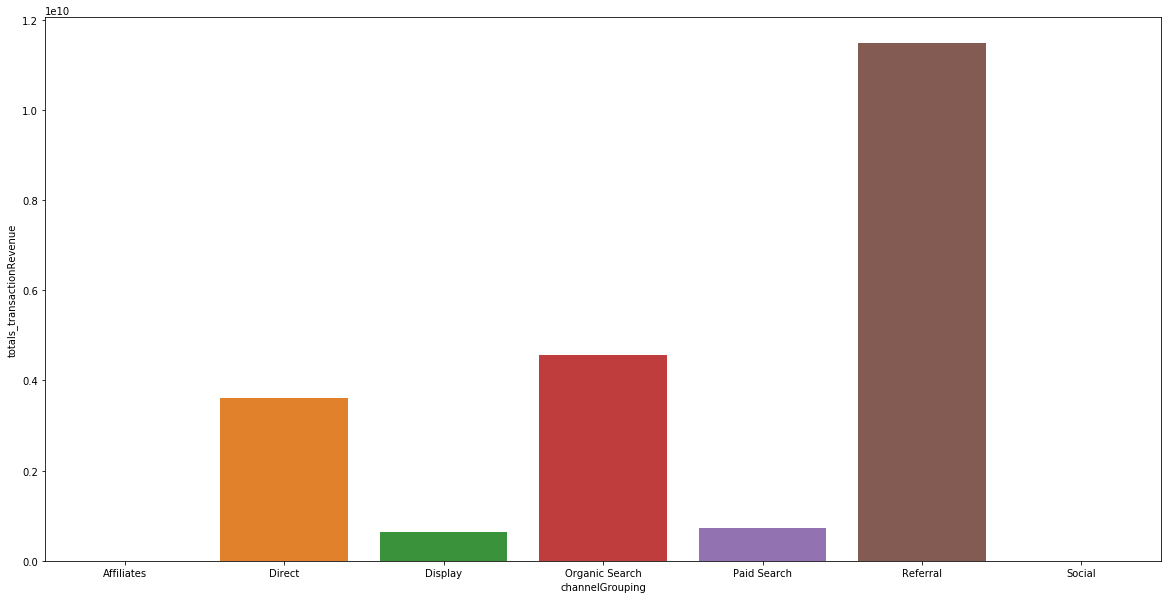

In [14]:
#Checking which channel leads to highest revenue
df_channel = df.groupby(['channelGrouping'], as_index = False)['totals_transactionRevenue'].sum()

y = df_channel['totals_transactionRevenue']
x = df_channel['channelGrouping']

fig, ax = plt.subplots(figsize=(20,10)) 
sns.barplot(x=x,y=y)

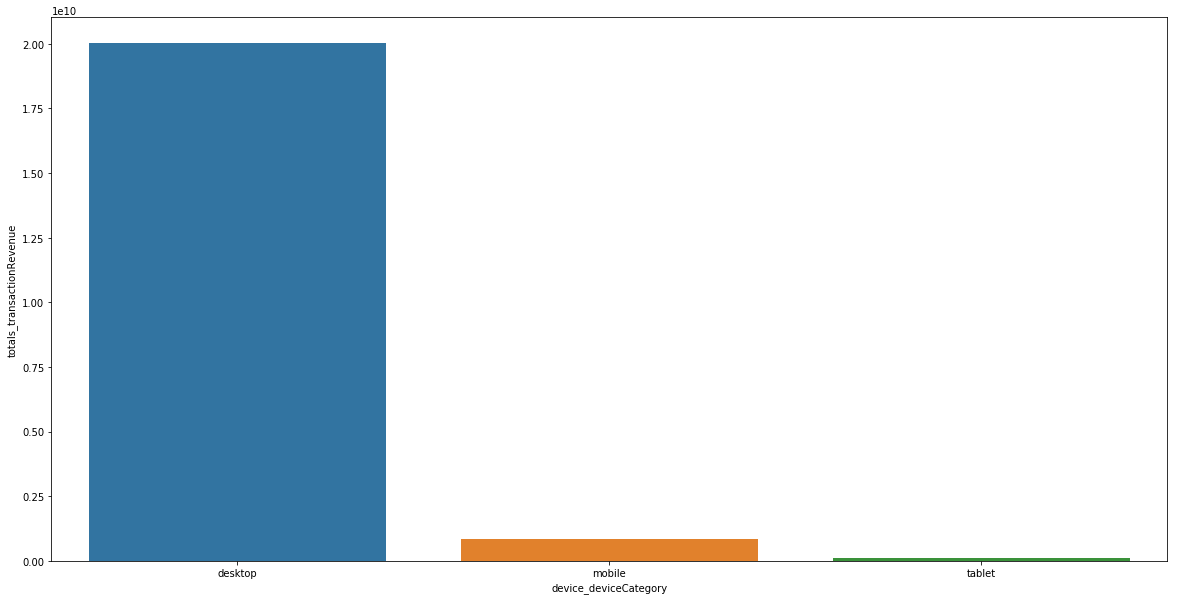

In [15]:
#Checking which device category leads to highest revenue
df_device_cat = df.groupby(['device_deviceCategory'], as_index = False)['totals_transactionRevenue'].sum()

y = df_device_cat['totals_transactionRevenue']
x = df_device_cat['device_deviceCategory']

fig, ax = plt.subplots(figsize=(20,10)) 
sns.barplot(x=x,y=y)

Text(0,0.5,'Total Revenue')

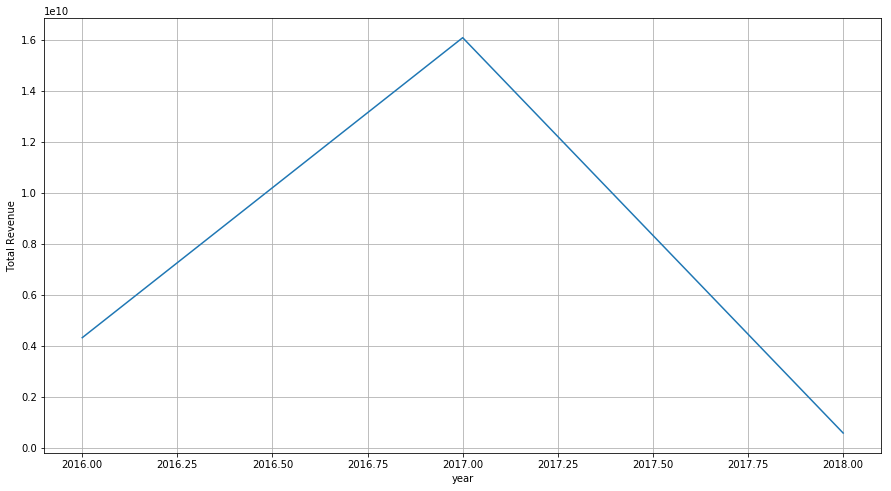

In [16]:
#Yearly trend
df_yearly = df.groupby(['year'])['totals_transactionRevenue'].sum()

plot_yearly_summary = df_yearly.plot(grid = True,figsize=(15,8), title="")
plot_yearly_summary.set_ylabel("Total Revenue")

Text(0,0.5,'Total Revenue')

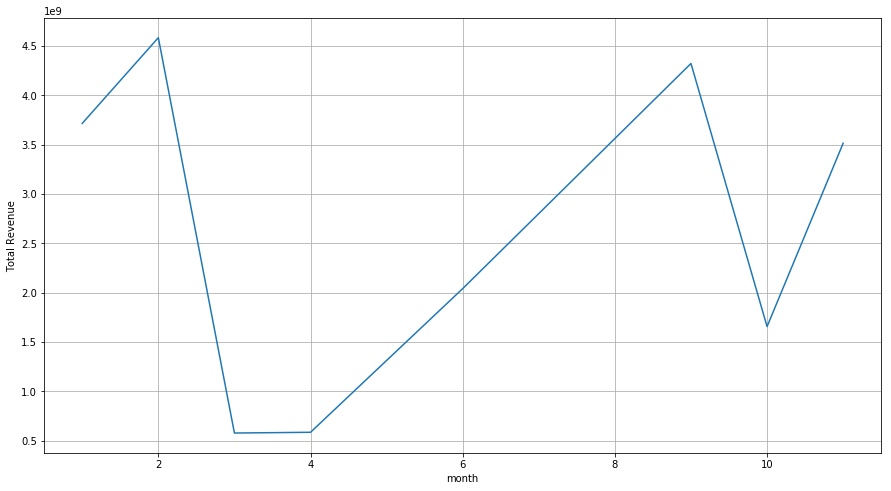

In [17]:
#Monthly trend
df_monthly = df.groupby(['month'])['totals_transactionRevenue'].sum()

plot_yearly_summary = df_monthly.plot(grid = True,figsize=(15,8))
plot_yearly_summary.set_ylabel("Total Revenue")

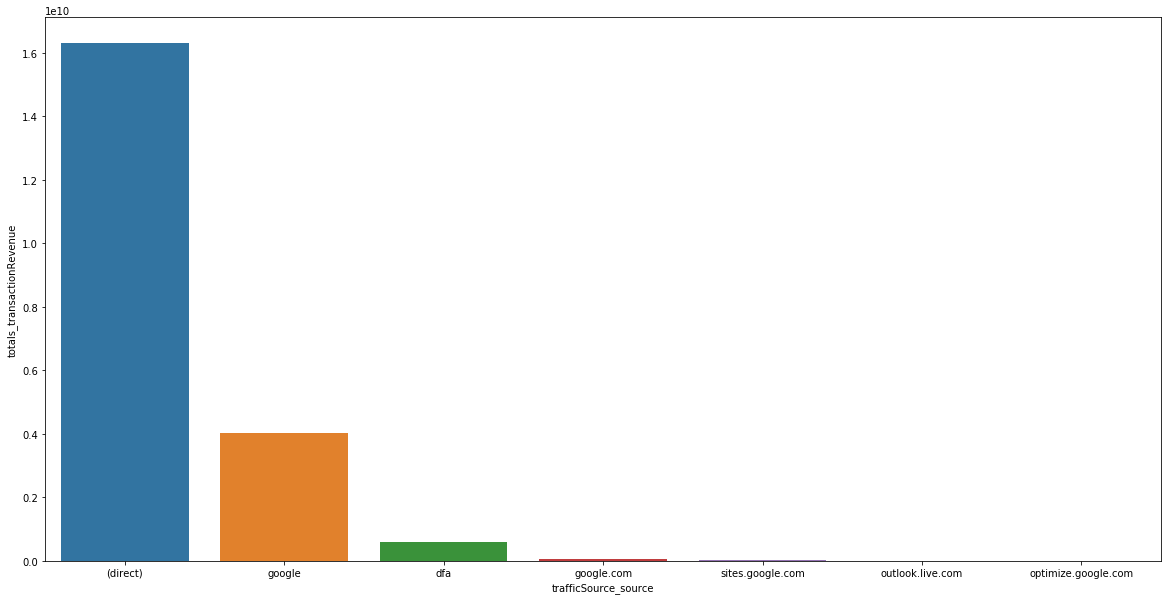

In [18]:
#Traffic Source of revenue generating visits
df_traffic_source = df.groupby(['trafficSource_source'], as_index = False)['totals_transactionRevenue'].sum()
df_traffic_source = df_traffic_source.sort_values(by = 'totals_transactionRevenue', ascending = False).head(7)
y = df_traffic_source['totals_transactionRevenue']
x = df_traffic_source['trafficSource_source']

fig, ax = plt.subplots(figsize=(20,10)) 
sns.barplot(x=x,y=y)

In [19]:
#Checking the correlation
df.corr()['totals_transactionRevenue']

visitId                                    -0.022747
visitNumber                                 0.011616
visitStartTime                             -0.022747
totals_bounces                             -0.052183
totals_hits                                 0.262387
totals_newVisits                           -0.062194
totals_pageviews                            0.270127
totals_sessionQualityDim                    0.100877
totals_timeOnSite                           0.143043
totals_totalTransactionRevenue              0.878877
totals_transactionRevenue                   1.000000
totals_transactions                         0.548267
device_isMobile                            -0.029310
trafficSource_adwordsClickInfo.isVideoAd   -0.000142
trafficSource_isTrueDirect                  0.045353
month                                      -0.009328
year                                       -0.016581
visitHour                                   0.005654
Name: totals_transactionRevenue, dtype: float6

In [20]:
#Removing totals_totalTransactionRevenue column as it has a very high correlation and is the sum 
#of all TransactionRevenue so cannot be used for modeling
df = df.drop('totals_totalTransactionRevenue', axis=1)

In [21]:
#Taking only the target variable
y = df['totals_transactionRevenue']
y.shape

(20000,)

#### UNSUPERVISED LEARNING


In [22]:
#Taking a subset of the data with only continuous/discrete data
df_num = df.select_dtypes(include = ['float','int32','int64','float64','float32'])
X = df_num.drop('totals_transactionRevenue', axis=1)
X = X.drop(['visitId','month','year'],axis=1)
X.columns

Index(['visitNumber', 'visitStartTime', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim',
       'totals_timeOnSite', 'totals_transactions', 'visitHour'],
      dtype='object')

In [23]:
X.isna().sum()

visitNumber                 0
visitStartTime              0
totals_bounces              0
totals_hits                 0
totals_newVisits            0
totals_pageviews            0
totals_sessionQualityDim    0
totals_timeOnSite           0
totals_transactions         0
visitHour                   0
dtype: int64

#### Scaling Data 

In [24]:
#Scaling data
scaler = StandardScaler()
scaler.fit(X)
XScaled = scaler.transform(X)

In [25]:
#Adding a column purchase 
df['Purchase'] = 0
df.loc[df['totals_transactionRevenue'] > 0, 'Purchase'] = 1

#### PCA

In [26]:
from sklearn.decomposition import PCA 
model = PCA(n_components=2)            
model.fit(XScaled)                     
X_2D = model.transform(XScaled) 

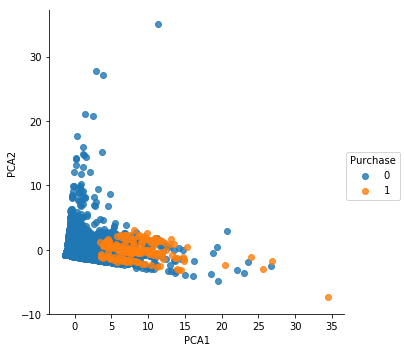

In [27]:
df['PCA1'] = X_2D[:, 0]
df['PCA2'] = X_2D[:, 1]
sns.lmplot("PCA1", "PCA2", data=df, hue ='Purchase', fit_reg=False);

#### CLUSTERING

#### Gaussian Mixture

In [28]:
from sklearn.mixture import GaussianMixture                      # 1. Choose the model class
model = GaussianMixture(n_components=2,covariance_type='full')  # 2. Instantiate the model with hyperparameters
model.fit(XScaled)                                                # 3. Fit to data. Notice y is not specified!
y_gmm = model.predict(XScaled) 

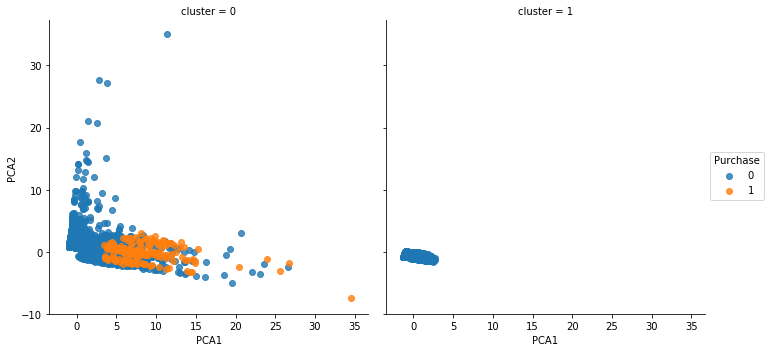

In [29]:
df['cluster'] = y_gmm
sns.lmplot("PCA1", "PCA2", data=df,hue ='Purchase', col='cluster', fit_reg=False, palette = 'tab10');

In [30]:
XScaled.shape

(20000, 10)

#### KMeans

In [31]:
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix

clusters=range(1,15)
meandistance=[]

for k in clusters:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(X)
    clusterAssignment=kmeans.predict(X)
    meandistance.append(sum(np.min(distance_matrix(X,kmeans.cluster_centers_,p=2),axis=1)/X.shape[0]))

Text(0.5,1,'Elbow method for selecting K')

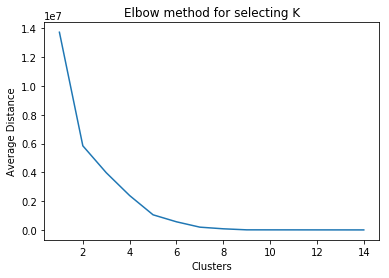

In [32]:
plt.plot(clusters,meandistance)
plt.xlabel('Clusters')
plt.ylabel('Average Distance')
plt.title('Elbow method for selecting K')

In [33]:
#Performing k means for 2 clusters
kmeans_2 =KMeans(n_clusters=2)
kmeans_2.fit(X)
cluster_kmeans = kmeans_2.predict(X)

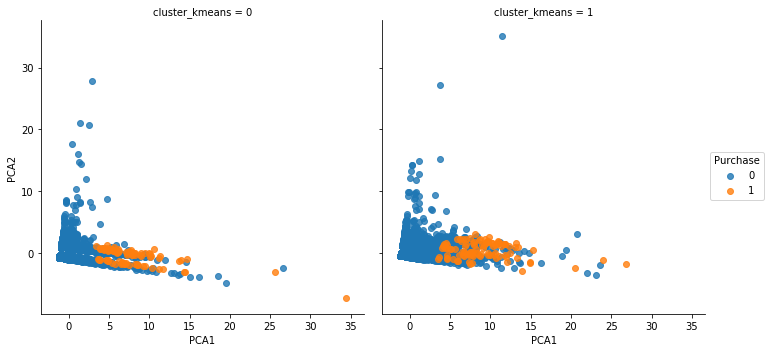

In [34]:
df['cluster_kmeans'] = cluster_kmeans
sns.lmplot("PCA1", "PCA2", data=df,hue ='Purchase', col='cluster_kmeans', fit_reg=False, palette = 'tab10');

#### SUPERVISED LEARNING

In [35]:
#Defining X and y again for supervised models
y = df['totals_transactionRevenue']
y.shape

df_num = df.select_dtypes(include = ['float','int32','int64','float64','float32'])
X = df_num.drop('totals_transactionRevenue', axis=1)
X = X.drop(['visitId','month','year'],axis=1)
X = X.drop(['Purchase','PCA1','PCA2','cluster','cluster_kmeans'],axis=1)
X.columns

Index(['visitNumber', 'visitStartTime', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim',
       'totals_timeOnSite', 'totals_transactions', 'visitHour'],
      dtype='object')

In [36]:
X.dtypes

visitNumber                   int64
visitStartTime                int64
totals_bounces              float64
totals_hits                   int64
totals_newVisits            float64
totals_pageviews            float64
totals_sessionQualityDim    float64
totals_timeOnSite           float64
totals_transactions         float64
visitHour                     int32
dtype: object

In [37]:
#X = X.drop(['Purchase','PCA1','PCA2','cluster','cluster_kmeans'],axis=1)

In [38]:
#Splitting into test and train
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

In [39]:
#Analyzing how the data has been split to see we have enough 
#non zero values in the training and test datasets

In [40]:
ytrain.mean()

1109014.6666666667

In [41]:
ytest.mean()

871232.0

In [42]:
sum(i > 0 for i in ytest)

49

In [43]:
sum(i > 0 for i in ytrain)

144

In [44]:
ytrain.shape

(15000,)

In [45]:
ytest.shape

(5000,)

In [46]:
from sklearn.metrics import accuracy_score 

#### Linear Regression - Starting with a basic model

In [47]:
#Linear Regression

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(Xtrain, ytrain)
reg.score(Xtrain, ytrain)
yPred = reg.predict(Xtest)
np.sqrt(mean_squared_error(ytest,yPred))

15070851.76091076

#### RMSE indicates the absolute fit of the model to the data and is a good parameter to measure of how accurately the model predicts the response

#### KNN Regression

In [48]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(Xtrain,ytrain)
model.best_params_

{'n_neighbors': 9}

In [51]:
model = neighbors.KNeighborsRegressor(n_neighbors = 9)
model.fit(Xtrain, ytrain) 
pred=model.predict(Xtest) 
error = sqrt(mean_squared_error(ytest,pred))
error

18803333.471028905

#### SGD Regressor

In [52]:
#SGD REGRESSOR
model = SGDRegressor()
model.fit(Xtrain,ytrain)
ypred = model.predict(Xtest)
np.sqrt(mean_squared_error(ytest,ypred))


C:\Users\aditi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


2.9274040524177404e+25

#### Dimensionality Reduction - FEATURE SELECTION

In [53]:
from sklearn.feature_selection import RFE

estimator = SGDRegressor() 
selector = RFE(estimator, 5, step=100)
selector.fit(Xtrain,ytrain)

C:\Users\aditi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\aditi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


RFE(estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False),
  n_features_to_select=5, step=100, verbose=0)

In [54]:
fs = selector.support_
xc = Xtrain.columns
res = xc[fs]
print(res)
col1 = ['visitNumber', 'totals_bounces', 'totals_newVisits','totals_sessionQualityDim', 'totals_transactions']
X_reduced = X.drop(col1,axis=1,inplace=True)

Index(['visitNumber', 'visitStartTime', 'totals_hits', 'totals_pageviews',
       'totals_timeOnSite'],
      dtype='object')


In [55]:
X.head()

,visitStartTime,totals_hits,totals_pageviews,totals_timeOnSite,visitHour
0,1508198450,1,1.0,0.0,19
1,1508176307,2,2.0,28.0,12
2,1508201613,2,2.0,38.0,19
3,1508169851,2,2.0,1.0,11
4,1508190552,2,2.0,52.0,16


#### Supervised Learning with Reduced Dimensions

#### KNN on reduced dimensions (PCA)

In [56]:
#Splitting into test and train using reduced dimensions - PCA
from sklearn.model_selection import train_test_split

Xtrain_2, Xtest_2, ytrain_2, ytest_2 = train_test_split(X_2D, y, random_state=1)

In [57]:
#KNN on Reduced dataset
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(Xtrain_2,ytrain_2)
model.best_params_

{'n_neighbors': 9}

In [58]:
model = neighbors.KNeighborsRegressor(n_neighbors = 9)
model.fit(Xtrain_2, ytrain_2) 
pred=model.predict(Xtest_2) 
error = sqrt(mean_squared_error(ytest_2,pred))
error

17378299.583839584

#### Using the reduced dimensionality to perform knn classifier it can be seen that the mean squared error has drastically reduced. This gives us a better result

In [59]:
#Linear Regression

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(Xtrain_2, ytrain_2)
reg.score(Xtrain_2, ytrain_2)
yPred = reg.predict(Xtest_2)
np.sqrt(mean_squared_error(ytest_2,yPred))

17643844.601376157

#### Using reduced dimensions on a Linear regression isn't helping in improving the mean square error

#### Reduced Dimension from Feature Selection used in Supervised Learning

In [136]:
#Splitting into test and train for feature selection
from sklearn.model_selection import train_test_split

Xtrain_FS, Xtest_FS, ytrain_FS, ytest_FS = train_test_split(X, y, random_state=1)

#### SGD 

In [137]:
#SGD REGRESSOR
model = SGDRegressor()
model.fit(Xtrain_FS,ytrain_FS)
ypred_FS = model.predict(Xtest_FS)
np.sqrt(mean_squared_error(ytest_FS,ypred_FS))

C:\Users\aditi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


1.1199568835156142e+27

#### The error doesn't improve with reduced dimensions for this algorithm

#### Linear Regression

In [144]:
#Linear Regression

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(Xtrain_FS, ytrain_FS)
reg.score(Xtrain_FS, ytrain_FS)
yPred = reg.predict(Xtest_FS)
np.sqrt(mean_squared_error(ytest_FS,yPred))

17586166.377414133

#### This again doesn't help improve the mean square error in a linear regression

#### Conclusion: PCA has helped reduce the mean square error for KNN Algorithm